**Notebook credit**: based on the F. Chollet's original notebook [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter02_mathematical-building-blocks.ipynb).

## A 10 class classification problem

今天: 把 grayscale images of handwritten digits (28 × 28 pixels) classify 为 0 ～ 9

我们将使用 MNIST dataset, a classic in the machine learning community.
- Has 60,000 training images, plus 10,000 test images
- Was assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s
- MNIST 就是 DL 的 “Hello World”.

## 在 Keras 中 Load the MNIST dataset

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

The MNIST dataset comes preloaded in Keras in four NumPy
arrays.

In [3]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


- `train_images` and `train_labels` form the *training set*, the data that the model will learn from
- model will then be tested on the *test set*, `test_images` and `test_labels`
- images are encoded as NumPy arrays
- labels are an array of digits, ranging from 0 to 9.

In [4]:
train_images.shape
# 60000 个手写数字, 每个的像素大小是 28 * 28

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
test_images.shape
# test dataset

(10000, 28, 28)

In [8]:
len(test_labels)

10000

In [9]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

**Workflow** will be as follows:
- we’ll feed the neural network the training data, `train_images` and `train_labels`
- network will then learn to associate images and labels
- we’ll ask the network to produce predictions for `test_images`
- we’ll verify whether these predictions match the labels from `test_labels`

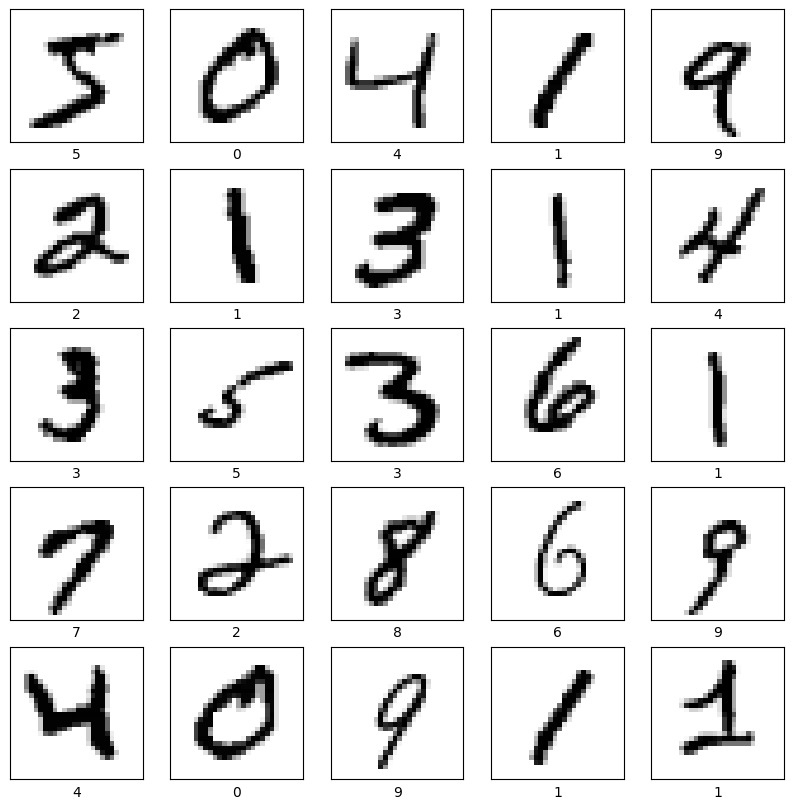

In [10]:
# Don't worry about the details of the plotting commands below. You won't be tested on this stuff.
plt.figure(figsize=(10,10))
for i in range(25):
    # 打印 25 个手写数学看看
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

**The network architecture**

- core building block of neural networks is the *layer*
- data goes into a layer, and it comes out in a more useful form
- layers extract representations out of the data fed into them—hopefully, representations that are more meaningful for the problem at hand
- most deep learning consists of chaining together simple layers



## Step(1) `keras.Sequential`: model 从 input layer 到 hidden layer 的过程
keras.sequential 是一个 API, 生成一个 "sequential" 的 model: 其实意思很简单，就是下面的操作是连续的，**前一个的 output 是后一个的 input.**

这个 sequential 中的任何一个 layer **如果声明是 `layers.Dense()`, 意思就是这一层和 fully connected 的：没有任何一个神经元在连接到下一层时被忽略.**

在 keras.sequential 中, 我们定义的其实是从 input layer 到所有 hidden layers 结束之间过程. 而在 下面的 `model.compile` 中，我们将写 model 的最后一个 layer: output layer.

### 我们的 Model 采取的 network architechture
这里可以看到，我们的 sequential 采取的架构是：
1. Flatten: 把每个 28 * 28 的 2d input tensor (matrix) 转化为 784 的 1d input tensor (vector).
$$
Flatten: \mathbb{R}^{28 \times 28} → \mathbb{R}^{784}
$$
（实际上是：）
$$
Flatten: \mathbb{R}^{n \times 28 \times 28} → \mathbb{R}^{n\times 784}\\
$$
$n$ 为数据点个数。

2. 对于每一个第一步得到的 784 的 1d input tensor 作为input，给一个权重矩阵进行一个线性变换：权重矩阵 $W \in \mathbb{R}^{512 \times 784}$，将 $\mathbb{R}^{784}$ 的 1d tensor 的 input 进去，ouput 出 $\mathbb{R}^{784}$ 的 1d tensor ，并对其中每个元素进行 relu 函数 ($max(0, x)$) 的操作，然后输出这个 $\mathbb{R}^{512}$ 的 1d tensor 作为结果。
由于其实有 n 个 data point，每个 data point 都是一个 784 的 1d input tensor, 所以输入和输出其实都是一个 matrix.

$$
Z = X \dot W + b
\\Y_1 = relu(Z)
$$


3. 通过 softmax 把每个第二步得到的 $\mathbb{R}^{512}$ 的 1d tensor 转化为一个 $\mathbb{R}^{10}$ 1d tensor. 其中所有 entry 的值都在 $[0,1]$ 范围内，并且 10 个 entry 的和为 1.

$$
Y_2 = softmax(Y_1)
$$



In [14]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

### Note: 最后一个 hidden layer 的 parameters 将是 optimizer 优化的操作对象, 而它会反向传播改变前面其他 hidden layers 的参数.

下一步，我们将把**最后一个 hidden layer 输出的**这个 $\mathbb{R}^{n \times 10}$ 的 2d tensor 传进 output layer!
也就是说：我们的 optimizer 的优化将是通过 最后一个 hidden layer 的 parameters 和 loss function 的值的关系(普遍是derivative)来进行的。

optimizer 改变最后一个 hidden layer 的 parameters，并通过 backward propagation 来改变前面所有 layers 的 parameters; backward propagation 过后再进行 forward propagation, 产生新的 loss function 的值.

Our model consists of:

- a layer that simply reshapes the input (therefore has no parameters)
- followed by a sequence of two `Dense` layers
- these are densely connected (also called *fully connected*) neural layers
- the last layer is a 10-way softmax classification layer
  - it will return an array of 10 probability scores (summing to 1)
  - each score will be the probability that the current digit image belongs to one of our 10 digit classes

Let's look at our model's summary. Can you compute the number of trainable parameters in each layer yourself?

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Step(2) `model.compile()`: output layer. 即模型的 optimizer, loss function 以及 mertric.

这一步包括了:
1. *optimizer*: training 过程中, model 每一次 backward propagation 自我更新 hyperparameter 所基于的机制. **比如我们常用的 SGD(随机梯度下降) 就是一个 optimizer.**

2. *loss function*: 衡量 model 的预测结果和真实结果的差异的函数. 还记得我们刚才说的: optimizer 改变最后一个 hidden layer 的 parameters，并通过 backward propagation 来改变前面所有 layers 的 parameters; backward propagation 过后再进行 forward propagation, 产生新的 loss function 的值.

3. *Metrics to monitor during training and testing*: 用于评估模型在训练完之后的准确性的 metrics. 其实这已经不是 training 的严格意义上的一部分了, 而是对 training 结果的评价. 因为我们知道：达到理想效果的 loss function 最后的值，根据 loss function 的选取的不同仍然差异很大，所以不同的 model 是无法比较 loss function 的值的。所以我们需要一个 metric 来比较 model 的训练实际效果：比如预测准确度就是一个很好的 metric. 在 10000 个 training/testing data 中，我们的模型预测成功了多少个？

In [18]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Node: 如何 **Prepare the image data**

- we’ll preprocess the data by scaling it so that all values are in the [0, 1] interval
- previously, our training images were stored in an array of shape (60000, 28, 28) of type `uint8` with values in the [0, 255] interval
- we’ll transform it into a `float64` array of shape (60000, 28, 28) with values between 0 and 1.

In [19]:
print(f"previously, train_images was of type {train_images.dtype}")
train_images = train_images / 255
test_images = test_images / 255
print(f"now, train_images is of type {train_images.dtype}")

previously, train_images was of type float64
now, train_images is of type float64


## Step(3) **"Fitting" the model**: 填入数据集和 hyperparameters

我们的模型已经设置完成，training 的最后一步是把数据和 hyperparameters(比如 learning rate, iteration 次数, batch size 和 regularizaition parameters 等.) fit in 进模型里.

注意: Hidden layers 中的 neurons 的数量也是一个 hyperparameter, 但并不是在 Data fitting 这一步填入的. 并不是所有 hyperparameters 都在这一步进行.

In [20]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 4s 4ms/step - loss: 2.2389 - accuracy: 0.2611
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 1.6920 - accuracy: 0.5918
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 1.0652 - accuracy: 0.7443
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.7592 - accuracy: 0.8105
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.6091 - accuracy: 0.8402



- Two quantities are displayed during training:
  - the loss of the model over the training data
  - the accuracy of the model over the training data
- We quickly reach an accuracy of 0.989 (98.9%) on the training data.

## Step(4): **Using the model to make predictions**, 即使用 Testing dataset 进行检验.

We can use out trained model to predict class probabilities for new digits—images in the test set (these were _not_ part of the training set)

In [21]:
predictions = model.predict(test_images)
predictions[0]

313/313 [==============================] - 1s 2ms/step


array([3.9087961e-04, 4.5884204e-05, 1.1667156e-04, 7.2842161e-04,
       1.2273655e-03, 1.4303298e-03, 6.3765442e-06, 9.7180700e-01,
       2.1671323e-04, 2.4030350e-02], dtype=float32)

In [22]:
print(predictions.shape)

(10000, 10)


- Each number of index `i` in that array corresponds to the probability that digit image test_digits[0] belongs to class `i`.
- This first test digit has the highest probability score (almost 1) at index 7, so according to our model, it must be a 7

In [23]:
predictions[0].argmax()

7

In [24]:
predictions[0][7]

0.971807

Our prediction agrees with the true test label.

In [25]:
test_labels[0]

7

**Evaluating the model on new data**

Let's compute average accuracy over the entire test set.

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 1s 3ms/step - loss: 0.5428 - accuracy: 0.8572
test_acc: 0.857200026512146


- test-set accuracy turns out to be around 98%
- that's a bit lower than the training-set accuracy (98.9%)
- gap between training accuracy and test accuracy is an example of *overfitting*:
  - ML models tend to perform worse on new data than on their training data
  - We will talk more about overfitting later in this course

## Step(5) **Visualizing first few predictions and first few mistakes**

_Note: this section is for visualization purposes only. You will not be tested on this stuff_

In [27]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

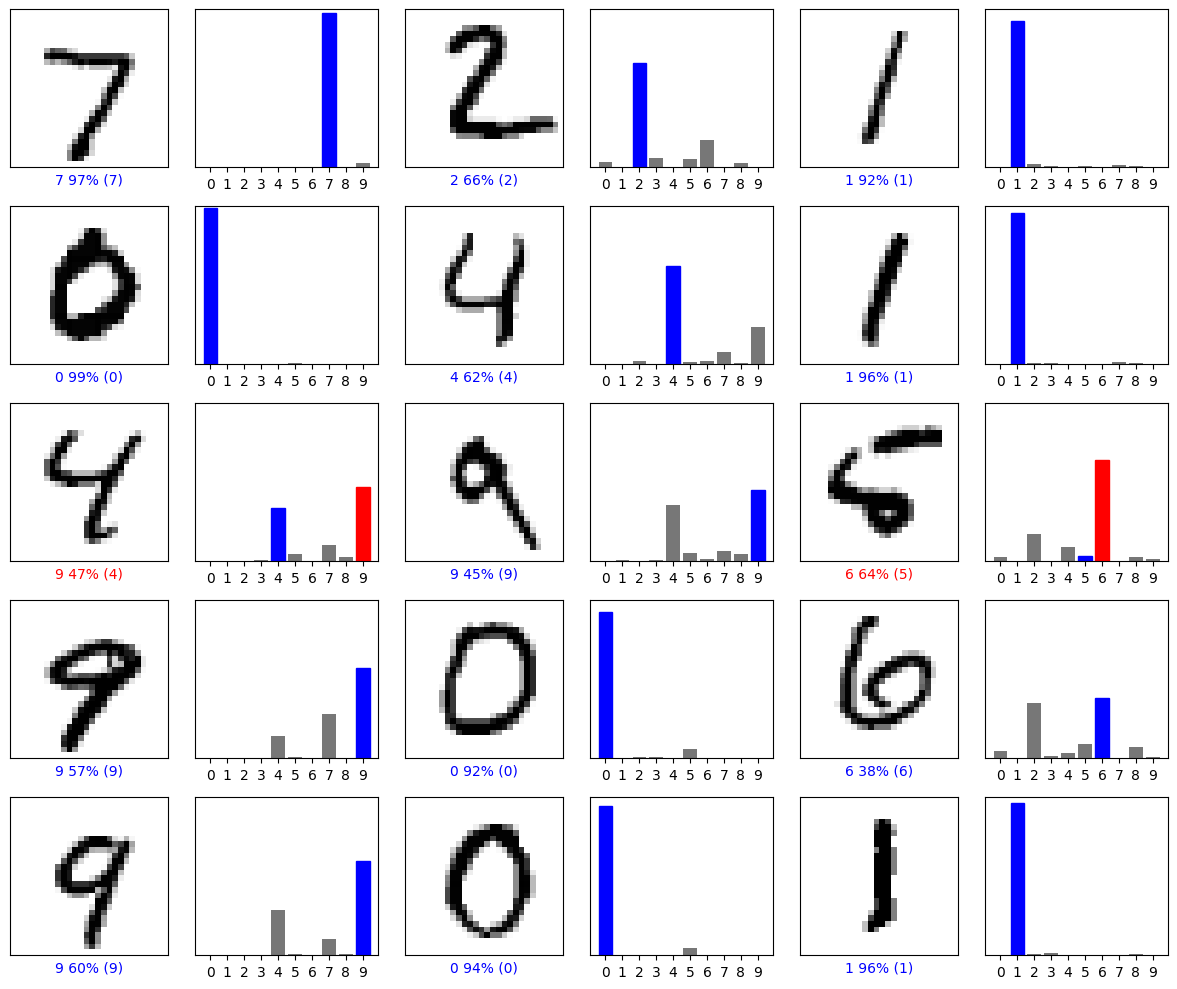

In [28]:
# plot first few predictions

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

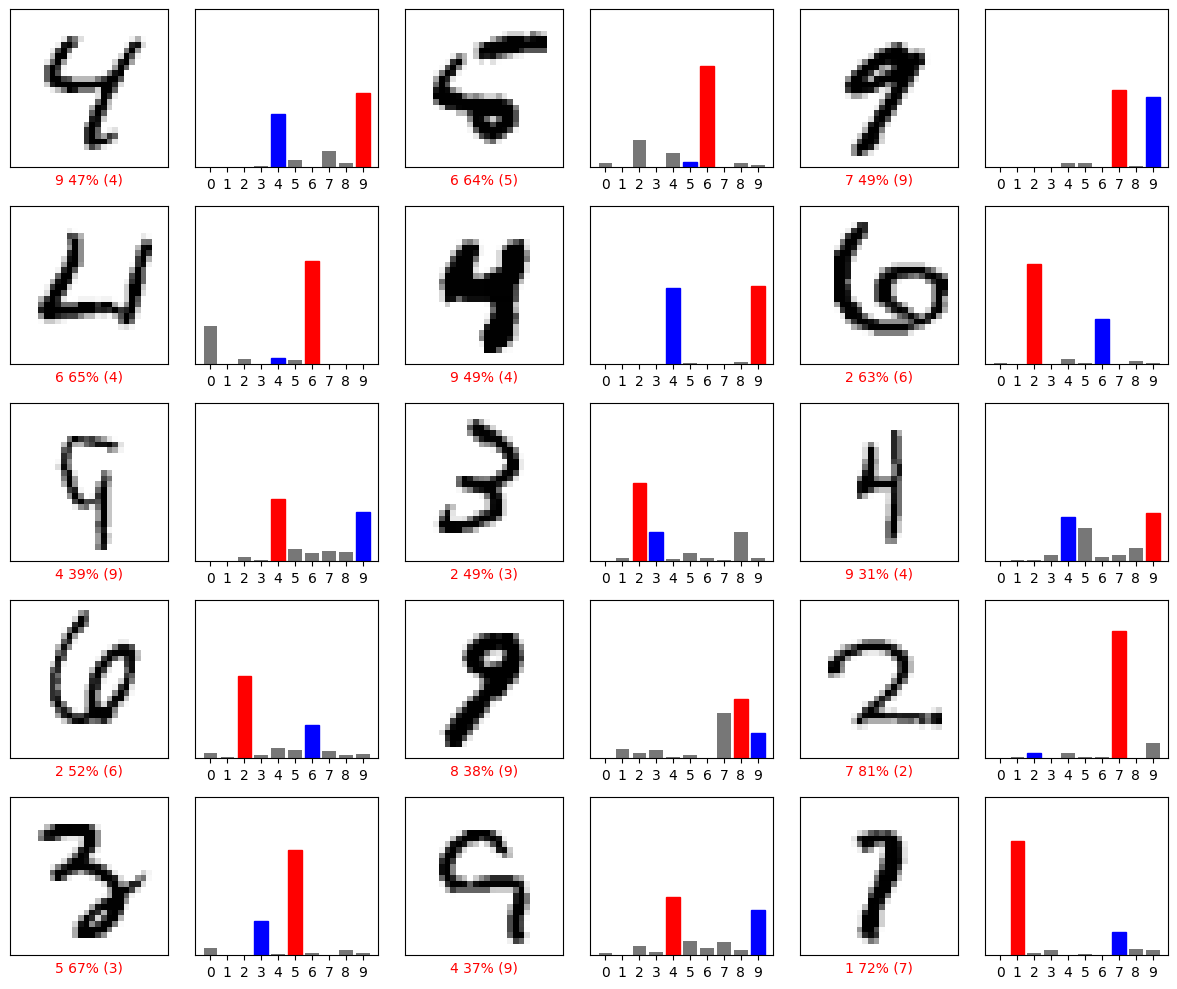

In [29]:
# plot first few mistakes

num_rows = 5
num_cols = 3
i, mistakes = 0, 0
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
while mistakes < num_rows*num_cols:
  if predictions[i].argmax() != test_labels[i]: # plot only if prediction incorrect
    plt.subplot(num_rows, 2*num_cols, 2*mistakes+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*mistakes+2)
    plot_value_array(i, predictions[i], test_labels)
    mistakes += 1
  i = i + 1
plt.tight_layout()
plt.show()

**Training a single layer network and visualizing network weights**

In [30]:
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 2.2904 - accuracy: 0.1246
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 2.2671 - accuracy: 0.1958
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 2.2444 - accuracy: 0.3131
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 2.2220 - accuracy: 0.4092
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 2.1999 - accuracy: 0.4902
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 2.1781 - accuracy: 0.5315
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 2.1566 - accuracy: 0.5690
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 2.1355 - accuracy: 0.6055
Epoch 9/10
469/469 [==============================] - 1s 3ms/step - loss: 2.1146 - accuracy: 0.6148
Epoch 10/10
469/469 [==============================] - 1s 3ms/step - loss: 2.0941 - accuracy: 0.6296

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 1s 2ms/step - loss: 2.0791 - accuracy: 0.6555
test_acc: 0.6554999947547913


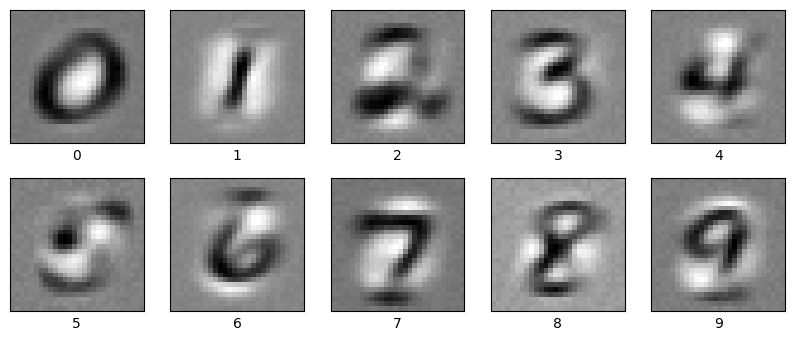

In [33]:
plt.figure(figsize=(10,4))
for i in range(10):
  w = model.layers[1].get_weights()[0][:,i].reshape([28, 28])
  plt.subplot(2,5,i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(w, cmap=plt.cm.binary) # larger values get darker shade
  plt.xlabel(i)
plt.show()

**Finding the training images that maximize the activation of outputs (before softmax)**

In [34]:
reshaped_images = train_images.reshape([60000, 784])
reshaped_images.shape # now in a shape that is compatible with multiplication with a 784 dim vector of weights

(60000, 784)

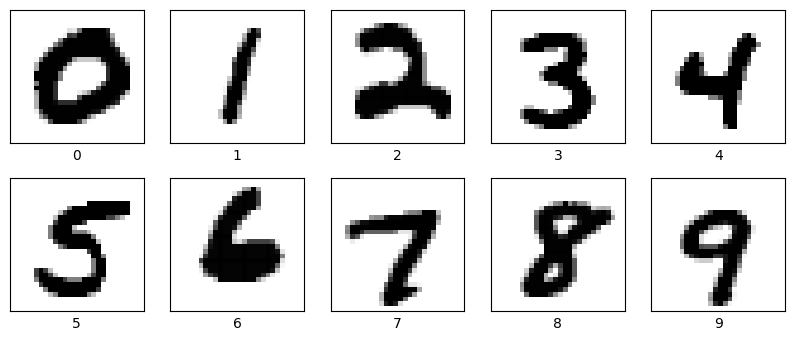

In [35]:
plt.figure(figsize=(10,4))
for i in range(10):
  w = model.layers[1].get_weights()[0][:,i]     # weight for digit i
  image_id = np.argmax(reshaped_images.dot(w))  # compute dot product with 60,000 images and find the image with maximum dot product
  plt.subplot(2,5,i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_images[image_id], cmap=plt.cm.binary) # larger values get darker shade
  plt.xlabel(i)
plt.show()